In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')
import sys, os, time
from slab import dsfit, dataanalysis
sys.path.append(r"S:\_Data\170422 - EonHe M018V6 with L3 etch")
from modules.Common import common
from experiment.data_cache import dataCacheProxy
from tqdm import tqdm
import scipy
print scipy.__version__
from mpltools import color
from scipy.interpolate import interp1d
from scipy import signal

0.15.1


In [2]:
def get_f0s(fpts, mags, span=2E6):
    f0s, Qs = list(), list()

    for k in tqdm(range(np.shape(mags)[0])):
        center_freq = fpts[k, np.argmax(mags[k,:])]
        try:
            fr = dsfit.fitlor(fpts[k,:], dataanalysis.dBm_to_W(mags[k,:]), 
                              domain=[center_freq-span/2., center_freq+span/2.])
            f0s.append(fr[2])
            Qs.append(fr[2]/(2*fr[3]))
        except:
            print "Fit failed!" 
            f0s.append(np.nan)
            Qs.append(np.nan)
        
    return f0s, Qs

def rgba(i, N, cmap=plt.cm.plasma):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=N)
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return m.to_rgba(i)

def Vtrap_separated(Vrg, mu):
    f_mu = -1.755-7*mu
    return (f_mu-0.120) - 1.15*Vrg

def Vrg_separated(Vtrap, mu):
    f_mu = -1.755-7*mu
    return -1/1.15*(Vtrap+(0.120-f_mu))
    
def Vtrap_avalanche(mu):
    return -0.120 - 1.69*mu

def Vrg_iso(contour=0.020):
    if contour >= 0.010:
        return 1/1.15 * (-0.22-0.32-10*contour) * 1/(1 + 1/1.15)
    else:
        return np.nan
    
def construct_line(x, point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    slope = (y2-y1)/(x2-x1)
    print "y = %.3f x + %.3f"%(slope, y1-slope*x1)
    return slope*(x-x1) + y1

def f(p, x):
    return (p[0] + np.arctan((p[1]-x)/p[2]))*180/np.pi

def g(p, x):
    return (p[0]+p[1]/(1+(x-p[2])**2/p[3]**2))

# Run from here

In [3]:
foldername = r"170805_165624_diagonal_sweep"
save = 1
mu = -0.280
skip_presweep = False #if foldername == "215303_load_and_diagonal_equal_dv" else True
f0_noE = 6.40511E9

filename = os.path.join(os.getcwd(), foldername, foldername+".h5")
d = dataCacheProxy(file_path=filename)

print d.index()
if not skip_presweep:
    fpts = d.get('fpts')
    mags = d.get('mags')
    phases = d.get("phases")
    
    Vrg = d.get('Vrg')
    Vtg = d.get('Vtg')
    

Vres = d.get('Vres')
Vtrap = d.get('Vtrap')
temperature= d.get('temperature')

nwa_config = d.get_dict("nwa_sweep_config")
nwa_calibration_config = d.get_dict("nwa_calibration_config")
voltage_log = d.get('voltage_log')

calibration_fpts = d.get('calibration_fpts')
calibration_idx = 0
calibration_mags = d.get('calibration_mags')
calibration_phases = d.get('calibration_phases')

presweep_Vtrap = d.get('presweep_Vtrap')[0]

fast_phases = d.get('fast_phases')
fast_mags = d.get('fast_mags')
fast_fpts = d.get('fast_fpts')
sweep_times = d.get('sweep_times')[0]
sweep_points = d.get('sweep_point')
fast_sweep_voltage_axis1 = d.get('sweep_voltage_1')
fast_sweep_voltage_axis2 = d.get('sweep_voltage_2')
fast_sweep_points = d.get('fast_sweep_points')
timetrace_avgs = d.get('timetrace_averages')

[u'Vpinch', u'Vres', u'Vrg', u'Vtg', u'Vtrap', u'calibration_fpts', u'calibration_idx', u'calibration_mags', u'calibration_phases', u'fast_fpts', u'fast_mags', u'fast_phases', u'fast_sweep_points', u'fpts', u'mags', u'nwa_calibration_config', u'nwa_sweep_config', u'phases', u'presweep_Vres', u'presweep_Vresguard', u'presweep_Vtrap', u'sweep_point', u'sweep_times', u'sweep_voltage_1', u'sweep_voltage_2', u'temperature', u'time', u'timetrace_averages', u'voltage_log']


## Raw data

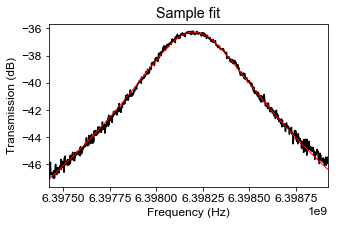

In [4]:
k = 0; span=2E6;
center_freq = calibration_fpts[k, np.argmax(calibration_mags[k,:])]
fr = dsfit.fitlor(calibration_fpts[k,:], dataanalysis.dBm_to_W(calibration_mags[k,:]), 
                  domain=[center_freq-span/2., center_freq+span/2.])
if skip_presweep:
    fdrive = fr[2]
else:
    fdrive = fpts[0, 0]

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(calibration_fpts[k,:], calibration_mags[k,:], '-k')
plt.plot(calibration_fpts[k,:], 30 + 10*np.log10(dsfit.lorfunc(fr,calibration_fpts[k,:])), '-r', lw=1.0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Transmission (dB)")
plt.xlim(np.min(calibration_fpts[k,:]), np.max(calibration_fpts[k,:]))
#print "Uncertainty in f0 in this fit is %.1f kHz"%(ferr[2]/1E3)
plt.title("Sample fit")

c:\users\slab\appdata\local\enthought\canopy32\user\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


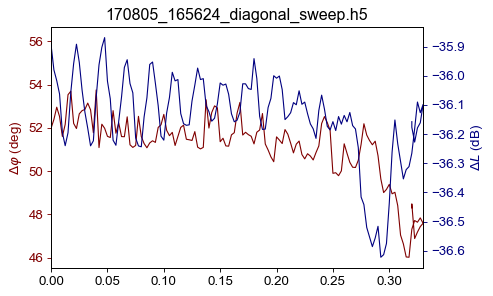

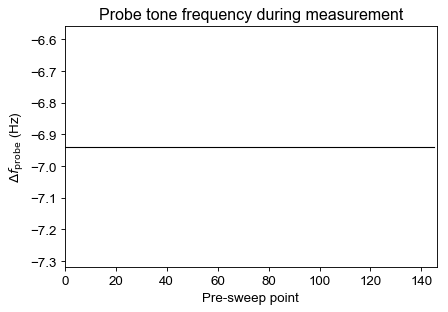

In [5]:
if not skip_presweep:
    mags_mu = np.mean(mags, axis=1)
    phases_mu = np.mean(phases, axis=1)
    phases_std = np.std(phases, axis=1)
    mags_std = np.std(mags, axis=1)
    f0_mu = np.zeros(len(phases_mu))
    adjusted_phases = np.zeros(len(phases_mu))

    color1 = 'maroon'; color2 = 'navy'
    idx = 0
    fig = plt.figure()
    plt.title(os.path.split(filename)[1])
    ax1, ax2 = common.setup_twinax(color1=color1, color2=color2)
    ax1.plot(presweep_Vtrap, phases_mu, color=color1, alpha=1, lw=1, 
             label="$V_\mathrm{trap}$ = %.3f"%(Vtrap[1 + np.argmax(Vtrap) + idx]))
    ax2.plot(presweep_Vtrap, mags_mu, '-', color=color2, alpha=1, lw=1)
    ax1.set_ylabel(r"$\Delta \varphi$ (deg)")
    ax2.set_ylabel(r"$\Delta L$ (dB)")
    plt.xlim(0, np.max(presweep_Vtrap))
    plt.xlabel("$V_\mathrm{trap}$")
    plt.legend(loc=0, prop={'size':10})
    
#     fig = plt.figure(figsize=(6.,8.))
#     plt.subplot(211)
#     plt.plot(presweep_Vtrap, phases_mu, '-k', lw=1, 
#              label=r"$\sigma/\sqrt{N}$ = %.3f deg"%(np.mean(phases_std)/sqrt(np.shape(phases)[1])))
#     plt.xlabel("$V_\mathrm{trap}$ (presweep)")
#     plt.ylabel(r"raw averaged $\varphi$ (deg)")
#     plt.xlim(0, np.max(presweep_Vtrap))
#     plt.title(os.path.split(filename)[1])
#     plt.legend(loc=0, prop={"size" : 10})

#     plt.subplot(212)
#     plt.plot(presweep_Vtrap, mags_mu, '-k', lw=1, 
#              label=r"$\sigma/\sqrt{N}$ = %.3f dB"%(np.mean(mags_std)/sqrt(np.shape(phases)[1])))
#     plt.xlabel("$V_\mathrm{trap}$ (presweep)")
#     plt.ylabel(r"raw averaged $|S_{21}|$ (dB)")
#     plt.xlim(0, np.max(presweep_Vtrap))
#     plt.legend(loc=0, prop={"size" : 10})
    
    if save:
        common.save_figure(fig, save_path=os.path.split(filename)[0])

    fig = plt.figure()
    plt.plot((fpts[:,0]-f0_noE)/1E6, '-k', lw=1)
    plt.xlabel("Pre-sweep point")
    plt.ylabel("$\Delta f_\mathrm{probe}$ (Hz)")
    plt.title("Probe tone frequency during measurement")
    plt.xlim(0, np.shape(fpts)[0])

    if save:
        common.save_figure(fig, save_path=os.path.split(filename)[0])

## Correct for any changes in the drive frequency, if necessary

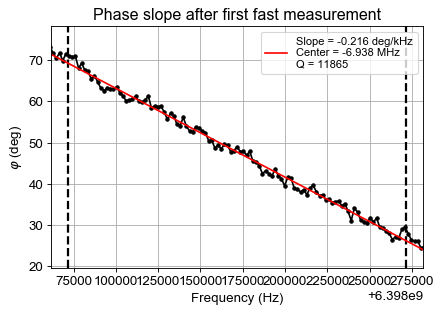

In [6]:
fast_calibration_phases = calibration_phases[-np.shape(fast_phases)[0]:]
fast_calibration_fpts = calibration_fpts[-np.shape(fast_phases)[0]:]
fast_calibration_mags = calibration_mags[-np.shape(fast_phases)[0]:]

adjusted_phases = np.zeros(np.shape(fast_phases))
N_traces = np.shape(fast_calibration_phases)[0]

slopes = list()
offsets = list()

for k in range(N_traces):
    center = fdrive
    span = 200E3
    fr = dsfit.fitlinear(fast_calibration_fpts[k,:], fast_calibration_phases[k,:], 
                         domain=(center-span/2., center+span/2.), fitparams=[0, -0.167E-3])
    slopes.append(fr[1])
    offsets.append(fr[0])
    
    phi0 = fr[0] + center*fr[1]
    adjusted_phases[k, :] = fast_phases[k, :] - slopes[0] * (center - fdrive)
        
f0_mu = -((adjusted_phases-offsets[0])/slopes[0] - fdrive)

fig = plt.figure()
common.configure_axes(12)
plt.title("Phase slope after first fast measurement")
center = fdrive #fpts[0,0]
xmin, xmax = center-1.1*span/2., center+1.1*span/2.
fr = dsfit.fitlor(fast_calibration_fpts[0,:], dataanalysis.dBm_to_W(fast_calibration_mags[0,:]), 
                  domain=(center-1E6, center+1E6))
Q = fr[2]/(2*fr[3])

plt.plot(fast_calibration_fpts[0,:], fast_calibration_phases[0,:], '-ok', ms=3)
plt.xlim(xmin, xmax)
ymax = fast_calibration_phases[0, common.find_nearest(fast_calibration_fpts[0,:], xmin)]+5
ymin = fast_calibration_phases[0, common.find_nearest(fast_calibration_fpts[0,:], xmax)]-5
plt.ylim(ymin, ymax)
plt.plot(fast_calibration_fpts[0,:], offsets[0]+fast_calibration_fpts[0,:]*slopes[0], '-r', 
         lw=1.5, label="Slope = %.3f deg/kHz\nCenter = %.3f MHz\nQ = %.0f"%(slopes[0]*1E3, (center-f0_noE)/1E6, Q))
plt.vlines([center-span/2., center+span/2.], ymin, ymax, linestyles='--', lw=2.0)
plt.ylabel(r"$\varphi$ (deg)")
plt.xlabel(r"Frequency (Hz)")
plt.grid()
plt.legend(loc=0, prop={"size" : 10})

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

## Use calibration traces to correct for a slow drift in the phase offset $\phi_0$

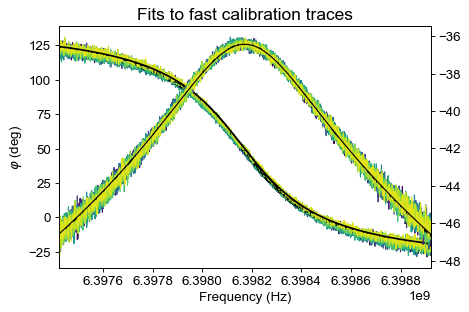

In [7]:
fitresults = list()
fitresults_mags = list()

color1='black'
color2='black'
fig = plt.figure()
ax1, ax2 = common.setup_twinax(color1=color1, color2=color2)
common.configure_axes(13)

for k in range(N_traces):
    ax1.plot(fast_calibration_fpts[k,:], fast_calibration_phases[k,:], lw=1, color=rgba(k, N_traces, cmap=plt.cm.viridis))
    
    xdata = fast_calibration_fpts[k,:]
    ydata = fast_calibration_phases[k,:]

    fr=dsfit.fitgeneral(xdata, ydata, f, [50/180.*np.pi, 6.3985E9, 350E3])
    ax1.plot(xdata, f(fr, xdata), '-k')
    fitresults.append(fr)
    
    ydata2 = dataanalysis.dBm_to_W(fast_calibration_mags[k,:])
    fr_mags=dsfit.fitlor(xdata, ydata2, domain=[fr[1]-0.75e6, fr[1]+0.75e6])
    
    fitresults_mags.append(fr_mags)
    
    ax2.plot(xdata, fast_calibration_mags[k,:], lw=1, color=rgba(k, N_traces, cmap=plt.cm.viridis))
    ax2.plot(xdata, dataanalysis.W_to_dBm(dsfit.lorfunc(fr_mags, xdata)), lw=1, color='k')
    
center = fast_calibration_fpts[0, np.argmax(fast_calibration_mags[0,:])]
ax1.set_xlim(np.min(fast_calibration_fpts), np.max(fast_calibration_fpts))
# plt.grid()
plt.title("Fits to fast calibration traces")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"$\varphi$ (deg)")

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

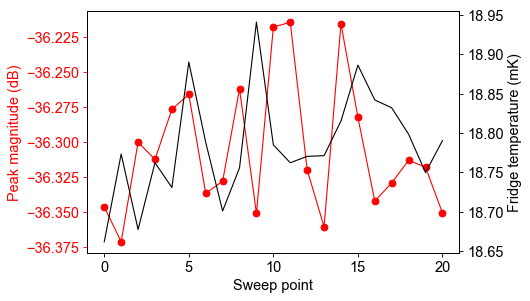

In [8]:
fig = plt.figure()
ax1, ax2 = common.setup_twinax(color1='red', color2='black')
ax2.plot(temperature[-np.shape(fast_phases)[0]:]*1E3, lw=1, color=color1)
ax1.plot(dataanalysis.W_to_dBm(np.array(fitresults_mags)[:,1]), '-or', lw=1)
ax1.set_xlabel("Sweep point")
ax1.set_ylabel("Peak magnitude (dB)", color='r')
ax2.set_ylabel("Fridge temperature (mK)")

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

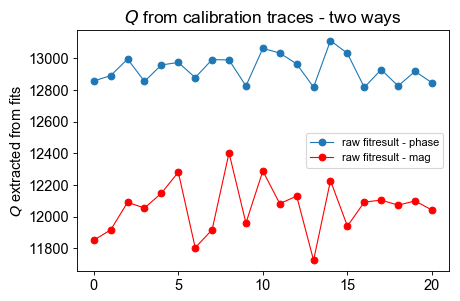

In [9]:
fig = plt.figure(figsize=(6.,4.))
plt.plot(range(N_traces), (np.array(fitresults)[:,1]/(2*np.array(fitresults)[:,2])), '-o', lw=1, label='raw fitresult - phase')
plt.plot(range(N_traces), (np.array(fitresults_mags)[:,2]/(2*np.array(fitresults_mags)[:,3])), '-or', lw=1, 
         label='raw fitresult - mag')

plt.ylabel(r"$Q$ extracted from fits")
plt.xlim(-1, N_traces)
plt.legend(loc=0, prop={"size" : 10})
plt.title("$Q$ from calibration traces - two ways")

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

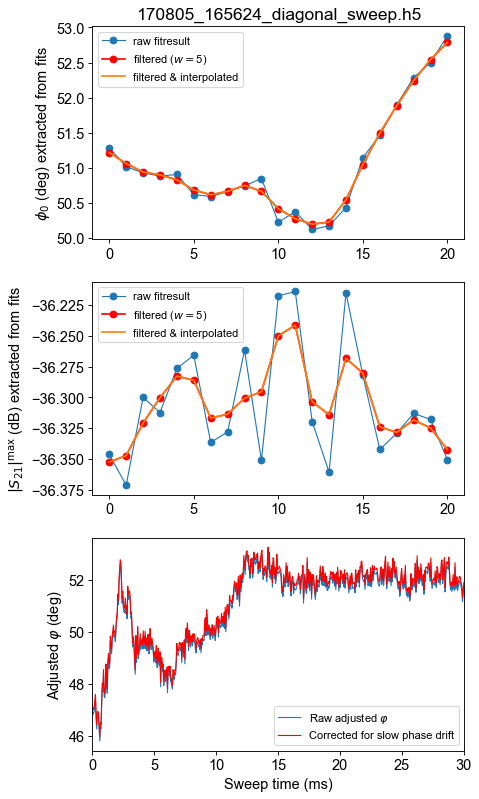

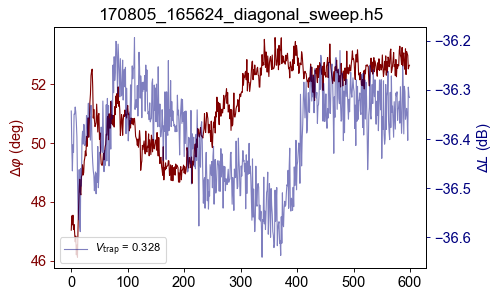

In [10]:
window_len = 5
make_up = 1 if not(window_len%2) else 0
win = signal.hann(window_len)
y1 = np.array(fitresults)[:,0]*180/np.pi
y2 = dataanalysis.W_to_dBm(np.array(fitresults_mags)[:,1])
y_prefilter = np.concatenate((y1[0]*np.ones(int(window_len/2.-make_up)), y1, y1[-1]*np.ones(int(window_len/2.))))
z_prefilter = np.concatenate((y2[0]*np.ones(int(window_len/2.-make_up)), y2, y2[-1]*np.ones(int(window_len/2.))))
y_filtered = signal.convolve(y_prefilter, win, mode='valid') / sum(win)
z_filtered = signal.convolve(z_prefilter, win, mode='valid') / sum(win)

finterp = interp1d(np.arange(N_traces), y_filtered, kind='linear', bounds_error=False)
ginterp = interp1d(np.arange(N_traces), z_filtered, kind='linear', bounds_error=False)

fig = plt.figure(figsize=(6.,12.))
plt.subplot(311)
plt.title(os.path.split(filename)[1])
plt.plot(range(N_traces), np.array(fitresults)[:,0]*180/np.pi, '-o', lw=1, label='raw fitresult')
plt.plot(range(N_traces), y_filtered, '-o', color='r', label='filtered ($w=$%.d)'%window_len)
plt.plot(range(N_traces), finterp(range(N_traces)), label='filtered & interpolated')
plt.ylabel(r"$\phi_0$ (deg) extracted from fits")
plt.legend(loc=0, prop={"size" : 10})

plt.subplot(312)
plt.plot(range(N_traces), y2, '-o', lw=1, label='raw fitresult')
plt.plot(range(N_traces), z_filtered, '-o', color='r', label='filtered ($w=$%.d)'%window_len)
plt.plot(range(N_traces), ginterp(range(N_traces)), label='filtered & interpolated')
plt.ylabel(r"$|S_{21}|^\max$ (dB) extracted from fits")
plt.legend(loc=0, prop={"size" : 10})


x = np.arange(N_traces)

plt.subplot(313)
plt.plot(sweep_times*1E3, adjusted_phases[10, :], lw=1, label=r"Raw adjusted $\varphi$")
plt.plot(sweep_times*1E3, adjusted_phases[10, :]-(finterp(15)-finterp(0)), '-r', lw=1, label="Corrected for slow phase drift")
plt.xlabel("Sweep time (ms)")
plt.ylabel(r"Adjusted $\varphi$ (deg)")
plt.xlim(0, np.max(sweep_times*1E3))
plt.legend(loc=0, prop={"size":10})

f0_mu_noslowdrift = np.zeros(np.shape(adjusted_phases))
mag_noslowdrift = np.zeros(np.shape(adjusted_phases))
for k in range(N_traces):
    if k == 0: 
        # Don't apply a calibration to this trace, we take this trace as the reference point:
        f0_mu_noslowdrift[k, :] = -((adjusted_phases[k, :]-offsets[0])/slopes[0] - fdrive)
    else:    
        f0_mu_noslowdrift[k, :] = -((adjusted_phases[k, :]-(finterp(k)-finterp(0))-offsets[0])/slopes[0] - fdrive)
    mag_noslowdrift[k, :] = fast_mags[k, :] - (ginterp(k)-ginterp(0))

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

axis1 = fast_sweep_voltage_axis1[0,:]
axis2 = fast_sweep_voltage_axis2[0,:]

color1 = 'maroon'; color2 = 'navy'
idx = 0
fig = plt.figure()
plt.title(os.path.split(filename)[1])
ax1, ax2 = common.setup_twinax(color1=color1, color2=color2)
ax2.plot(fast_mags[idx,:], color=color2, alpha=.5, lw=1, 
         label="$V_\mathrm{trap}$ = %.3f"%(Vtrap[1 + np.argmax(Vtrap) + idx]))
ax1.plot(adjusted_phases[idx,:], '-', color=color1, alpha=1, lw=1)
ax1.set_ylabel(r"$\Delta \varphi$ (deg)")
ax2.set_ylabel(r"$\Delta L$ (dB)")
plt.legend(loc=0, prop={'size' : 10})

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

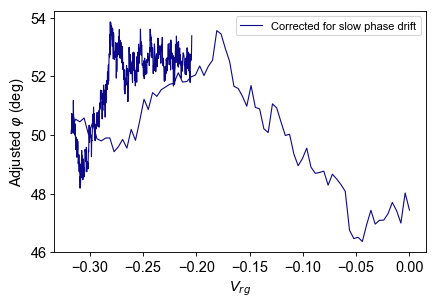

In [11]:
fig = plt.figure()
select = range(9,10)
for i, k in enumerate(select):
#     plt.plot(sweep_times*1E3, adjusted_phases[k, :], lw=1, label=r"Raw adjusted $\varphi$")
    plt.plot(fast_sweep_voltage_axis1[k, :], adjusted_phases[k, :]-(finterp(k)-finterp(0)), '-r', 
             color=rgba(i, len(select)), lw=1, label="Corrected for slow phase drift")
plt.xlabel("$V_{rg}$")
plt.ylabel(r"Adjusted $\varphi$ (deg)")
plt.legend(loc=0, prop={"size":10})

Let's look how well the slow phase drift compensation worked for us. 

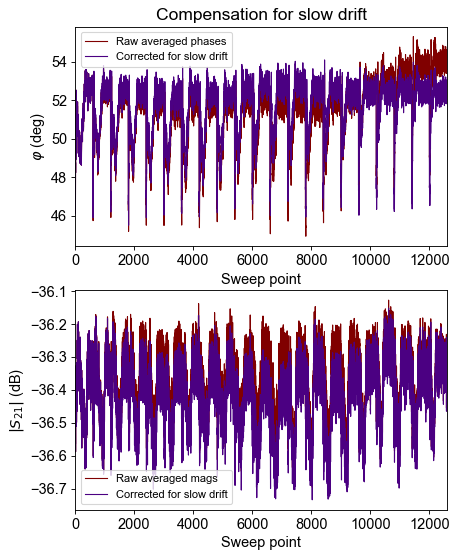

In [12]:
adjusted_phases_no_slowdrift = np.zeros(np.shape(adjusted_phases))
for k in range(N_traces):
    adjusted_phases_no_slowdrift[k, :] = adjusted_phases[k, :]-(finterp(k)-finterp(0))

fig = plt.figure(figsize=(6.,8.))
plt.subplot(211)
# plt.plot(fast_phases.flatten(), lw=1, color='maroon')
plt.plot(adjusted_phases.flatten(), lw=1, color='maroon', label="Raw averaged phases")
plt.plot(adjusted_phases_no_slowdrift.flatten(), lw=1, color='indigo', label="Corrected for slow drift")
plt.legend(loc=0, prop={"size" : 10})
plt.xlim(0, len(adjusted_phases_no_slowdrift.flatten()))
plt.xlabel("Sweep point")
plt.ylabel(r"$\varphi$ (deg)")
plt.title("Compensation for slow drift")

plt.subplot(212)
plt.plot(fast_mags.flatten(), lw=1, color='maroon', label="Raw averaged mags")
plt.plot(mag_noslowdrift.flatten(), lw=1, color='indigo', label="Corrected for slow drift")
plt.legend(loc=0, prop={"size" : 10})
plt.xlim(0, len(adjusted_phases_no_slowdrift.flatten()))
plt.xlabel("Sweep point")
plt.ylabel(r"$|S_{21}|$ (dB)")

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

Some traces belong to the same voltage point. The NWA can only average for 999 times. After this, we have to extract the data from the machine and restart the averaging. The last averaging is done in the block below.

In [13]:
averaged_f0_mu = np.zeros((len(np.unique(sweep_points)), np.shape(f0_mu)[1]))
averaged_fast_mags = np.zeros((len(np.unique(sweep_points)), np.shape(f0_mu)[1]))
change_sweep_points = np.diff(sweep_points)
for i, k in enumerate(np.unique(sweep_points)):
    appropriate_idcs = np.where(sweep_points == k)[0]
    total_averages = np.sum(timetrace_avgs[appropriate_idcs])
    averaged_f0_mu[k, :] = np.dot(timetrace_avgs[appropriate_idcs], f0_mu_noslowdrift[appropriate_idcs, :]) / total_averages
    averaged_fast_mags[k, :] = np.dot(timetrace_avgs[appropriate_idcs], mag_noslowdrift[appropriate_idcs, :]) / total_averages

In [14]:
fast_sweep_points

array([[ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520],
       [ 80, 520]])

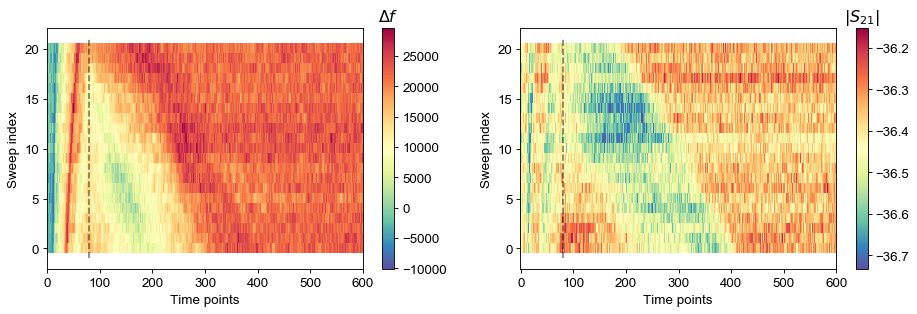

In [15]:
fig = plt.figure(figsize=(14.,4.))
common.configure_axes(12)
plt.subplot(121)
plt.imshow(averaged_f0_mu, aspect='auto', cmap=plt.cm.Spectral_r, interpolation='none', origin='lower')
cbar = plt.colorbar()
cbar.ax.set_title('$\Delta f$')
plt.xlabel("Time points")
plt.ylabel("Sweep index")
plt.vlines(fast_sweep_points[0,0], -1, np.shape(averaged_f0_mu)[0], linestyles='--', alpha=0.5)

plt.subplot(122)
plt.imshow(averaged_fast_mags, aspect='auto', cmap=plt.cm.Spectral_r, interpolation='none', origin='lower')
cbar = plt.colorbar()
cbar.ax.set_title('$|S_{21}|$')
plt.xlabel("Time points")
plt.ylabel("Sweep index")
plt.vlines(fast_sweep_points[0,0], -1, np.shape(averaged_fast_mags)[0], linestyles='--', alpha=0.5)

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

Note that in the figure above, the kink in the trace actually happens at a constant time points, but the voltage that's associated with that time point changes for each trace. In other words, dV for each timetrace is different. This means that diagonal features in this plot may happen at the same trap voltage for example.

c:\users\slab\appdata\local\enthought\canopy32\user\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.]


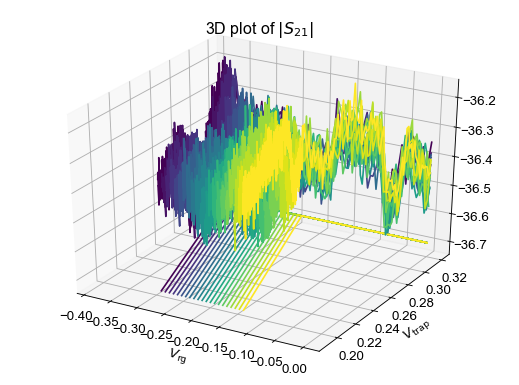

In [16]:
# For averaged data, we will need to plot the right voltages. The indices are given in appropriate_idcs
appropriate_idcs = np.append(np.zeros(1), 1+np.where(np.diff(sweep_points) == 1)[0])
sweep_points[appropriate_idcs.astype(int)]
color.cycle_cmap(len(appropriate_idcs), cmap=plt.cm.viridis)
print appropriate_idcs

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8.,6.))
common.configure_axes(12)
ax = fig.add_subplot(111, projection='3d')

for i, k in enumerate(appropriate_idcs.astype(int)):
    plt.plot(fast_sweep_voltage_axis1[k,:], fast_sweep_voltage_axis2[k,:], 
             zs=np.min(fast_mags) * np.ones(len(fast_sweep_voltage_axis1[k,:])))
    
for i, k in enumerate(appropriate_idcs.astype(int)):
    plt.plot(fast_sweep_voltage_axis1[k,:], fast_sweep_voltage_axis2[k,:], zs=averaged_fast_mags[i,:])
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}$")
plt.title("3D plot of $|S_{21}|$")

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

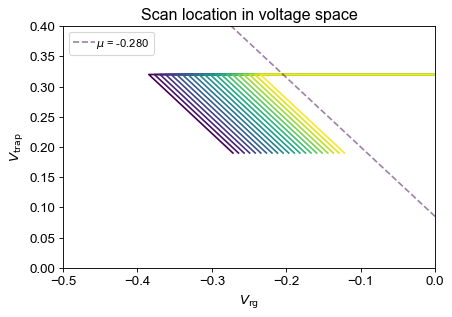

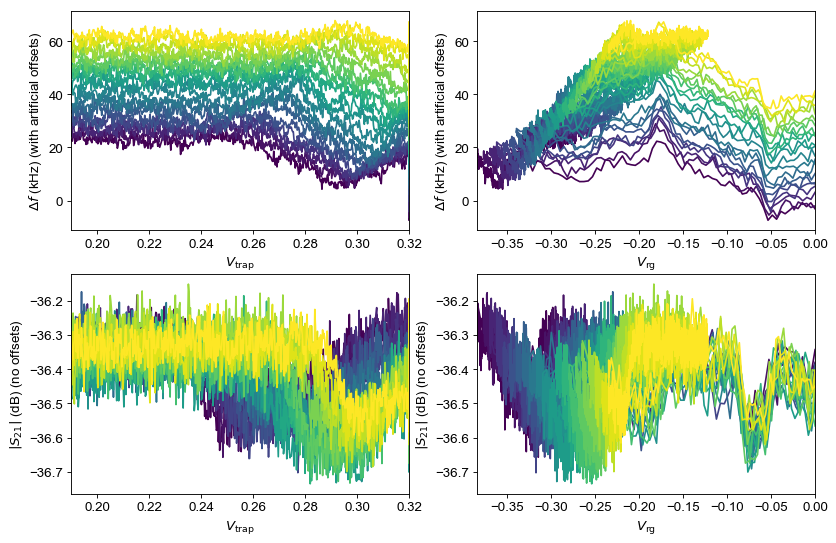

In [17]:
fig1 = plt.figure(figsize=(6.,4))
common.configure_axes(12)
for k in appropriate_idcs.astype(int):
    plt.plot(fast_sweep_voltage_axis1[k,:], fast_sweep_voltage_axis2[k,:])
plt.plot(np.linspace(0, -0.30), Vtrap_separated(np.linspace(0, -0.30), mu), '--', alpha=0.5, label=r"$\mu$ = %.3f"%mu)
plt.xlim(-0.5, 0)
plt.ylim(0, 0.4)
plt.title("Scan location in voltage space")
plt.legend(loc=2, prop={"size":10}, labelspacing=0.1, handletextpad=0.1)
plt.ylabel("$V_\mathrm{trap}$")
plt.xlabel("$V_\mathrm{rg}$")

fig2 = plt.figure(figsize=(12.,8))
common.configure_axes(12)
plt.subplot(223)
for i, k in enumerate(appropriate_idcs.astype(int)):
    plt.plot(fast_sweep_voltage_axis2[k,:], averaged_fast_mags[i,:])
plt.ylabel("$|S_{21}|$ (dB) (no offsets)")
plt.xlabel("$V_\mathrm{trap}$")
plt.xlim(np.min(fast_sweep_voltage_axis2), np.max(fast_sweep_voltage_axis2))


plt.subplot(221)
for i, k in enumerate(appropriate_idcs.astype(int)):
    plt.plot(fast_sweep_voltage_axis2[k,:], (i*2E3 + averaged_f0_mu[i,:])/1E3)
plt.ylabel("$\Delta f$ (kHz) (with artificial offsets)")
plt.xlabel("$V_\mathrm{trap}$")
plt.xlim(np.min(fast_sweep_voltage_axis2), np.max(fast_sweep_voltage_axis2))

    
plt.subplot(222)
for i, k in enumerate(appropriate_idcs.astype(int)):
    plt.plot(fast_sweep_voltage_axis1[k,:], (i*2E3 + averaged_f0_mu[i,:])/1E3)
plt.ylabel("$\Delta f$ (kHz) (with artificial offsets)")
plt.xlabel("$V_\mathrm{rg}$")
plt.xlim(np.min(fast_sweep_voltage_axis1), np.max(fast_sweep_voltage_axis1))
    

plt.subplot(224)
for i, k in enumerate(appropriate_idcs.astype(int)):
    plt.plot(fast_sweep_voltage_axis1[k,:], averaged_fast_mags[i,:])
plt.ylabel("$|S_{21}|$ (dB) (no offsets)")
plt.xlabel("$V_\mathrm{rg}$")
plt.xlim(np.min(fast_sweep_voltage_axis1), np.max(fast_sweep_voltage_axis1))


if save:
    common.save_figure(fig1, save_path=os.path.split(filename)[0])
    common.save_figure(fig2, save_path=os.path.split(filename)[0])

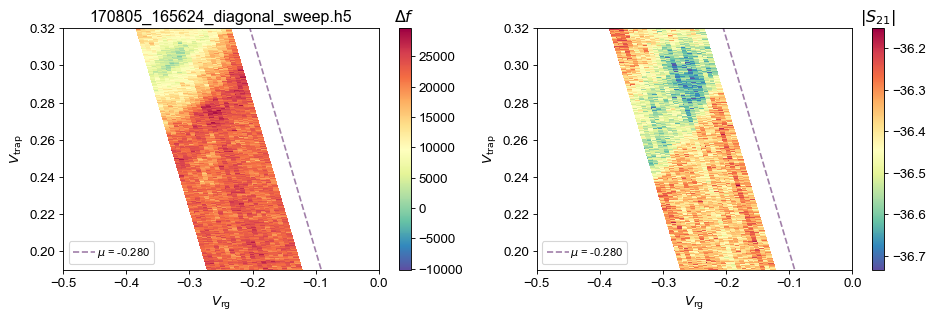

In [18]:
axis1 = fast_sweep_voltage_axis1[appropriate_idcs.astype(int),:]
axis2 =  fast_sweep_voltage_axis2[appropriate_idcs.astype(int),:]

fig1=plt.figure(figsize=(14.,4.))
common.configure_axes(12)
plt.subplot(121)
plt.pcolormesh(axis1, axis2, averaged_f0_mu, cmap=plt.cm.Spectral_r)
plt.title(os.path.split(filename)[1])
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}$")

plt.plot(np.linspace(0, -0.30), Vtrap_separated(np.linspace(0, -0.30), mu), '--', alpha=0.5, label=r"$\mu$ = %.3f"%mu)
plt.ylim(np.min(axis2), np.max(axis2))
plt.xlim(-0.5, -0.0)
cbar = plt.colorbar()
cbar.ax.set_title('$\Delta f$')
plt.legend(loc=3, prop={"size":10}, labelspacing=0.1, handletextpad=0.1)

plt.subplot(122)
plt.pcolormesh(axis1, axis2, averaged_fast_mags, cmap=plt.cm.Spectral_r) #vmin=-37.5, vmax=-37.0) #
# plt.title(os.path.split(filename)[1])
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}$")
cbar = plt.colorbar()
cbar.ax.set_title('$|S_{21}|$')
plt.plot(np.linspace(0, -0.30), Vtrap_separated(np.linspace(0, -0.30), mu), '--', alpha=0.5, label=r"$\mu$ = %.3f"%mu)
# plt.plot(np.linspace(0, -0.40), construct_line(np.linspace(0, -0.40), (-0.27, 0.22), (-0.35, 0.20)), '--k', alpha=0.5)
plt.legend(loc=3, prop={"size":10}, labelspacing=0.1, handletextpad=0.1)
plt.ylim(np.min(axis2), np.max(axis2))
plt.xlim(-0.5, -0.0)

if save:
    common.save_figure(fig1, save_path=os.path.split(filename)[0])

## Electron loading

In [19]:
try:
    f0_premeas = d.get('f0_pre_meas')
    Q_premeas = d.get('Q_pre_meas')
    
    fig = plt.figure()
    common.configure_axes(12)
    ax1, ax2 = common.setup_twinax(color1='b', color2='g')
    plt.title("Trying to regulate the electron density on the resonator")
    common.configure_axes(13)
    ax1.plot((f0_premeas-f0_noE)/1E6, '-o', color='b')
    ax2.plot(Q_premeas, '-d', color='g')
    ax2.set_ylabel("$Q$")
    ax1.set_ylabel("$\Delta f$ (MHz)")
    ax1.set_xlabel("Unloading attempt")

    if save:
        common.save_figure(fig, save_path=os.path.split(filename)[0])
except:
    print "No pre measurement traces found!"
    pass

No pre measurement traces found!
